# k-Means

A quick reminder on how k-Means works: https://youtu.be/0ZGTBQxf_Nw.

Key ideas:
* a cluster is determined by the nearest centroid;
* the centroids are re-positions within the new clusters.

Advantages:
* simple;
* efficient on large datasets;
* able to incorporate new data without a complete retrain.

Disadvantages:
* needs to know the number of clusters in advance;
* each run can lead to different results;
* sensitive to outliers (can "trap" a centroid);
* sensitive to the number and scale of dimensions - curse of dimensionality (same as for k-NN).

Considering the following uni-dimensional dataset:

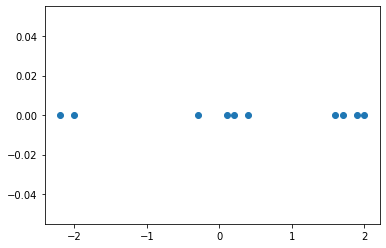

In [1]:
import pandas as pd
d = pd.DataFrame({
    'X': [-2.2, -2.0, -0.3, 0.1, 0.2, 0.4, 1.6, 1.7, 1.9, 2.0],
})

# Plot the dataset
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(d, np.zeros_like(d))
plt.show()

we can run the k-means algorithm for 3 clusters using `sklearn` with:

In [2]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=1)
clusters = km.fit_predict(d)

print(clusters)

[1 1 0 0 0 0 2 2 2 2]


And, as usual, we can represent them in the original scatter plot:

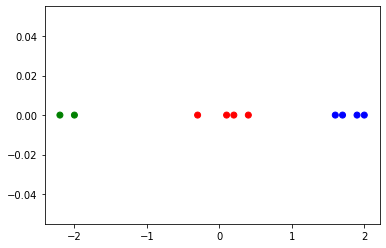

In [3]:
from matplotlib.colors import ListedColormap
c = ListedColormap(['red', 'green', 'blue'])
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.show()

We can also visualise the current centroids, which are accessible through the `cluster_centers_` attribute:

Centroids:  [ 0.1 -2.1  1.8]


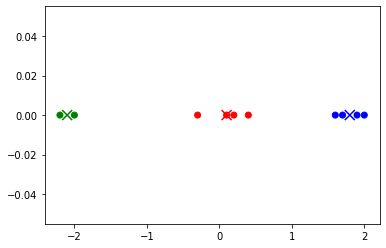

In [4]:
x_centroids = km.cluster_centers_[:,0]
print('Centroids: ', x_centroids)
# Scatter plot including centroids
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
            c=range(len(x_centroids)), cmap=c)
plt.show()

## The random nature of the algorithm

In its simplest form, the algorithm will initialise the centroids by choosing random starting points. We can visualise this by setting the `init` parameter to `random` and running a single initialization with a single step, using various random seeds:

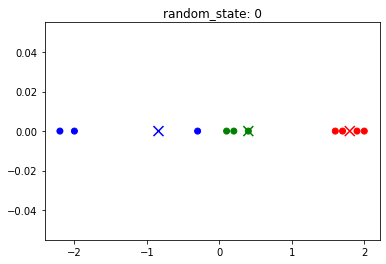

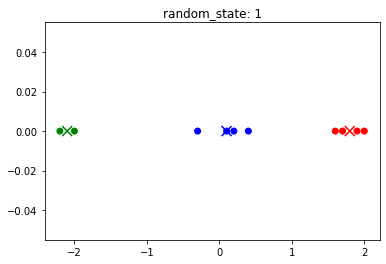

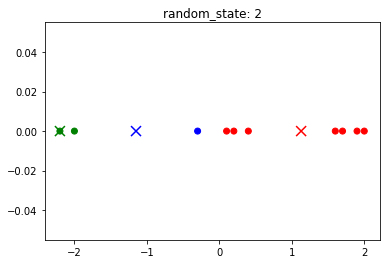

In [5]:
for seed in range(3):
    km = KMeans(init='random', n_init=1, max_iter=1, n_clusters=3, random_state=seed)
    clusters = km.fit_predict(d)
    x_centroids = km.cluster_centers_[:,0]
    # Scatter plot including centroids
    plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
    plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
                c=range(len(x_centroids)), cmap=c)
    plt.title(f'random_state: {seed}')
    plt.show()

## Convergence criteria

The algorithm will keep updating the centroids until their position no longer changes. We can visualise this by using different values for the `max_iter` parameter (controlling the maximum number of iterations):

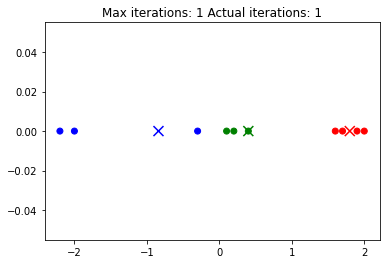

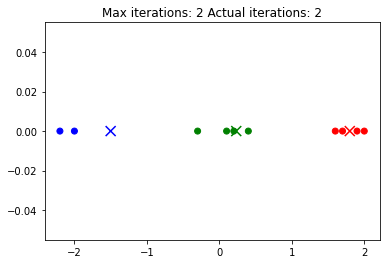

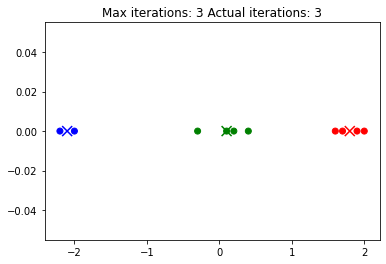

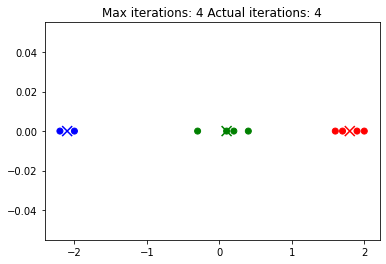

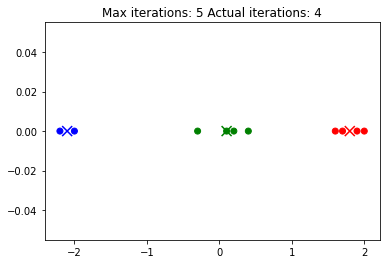

In [6]:
for max_iter in range(1,6):
    km = KMeans(init='random', n_init=1, max_iter=max_iter, n_clusters=3, random_state=0)
    clusters = km.fit_predict(d)
    x_centroids = km.cluster_centers_[:,0]
    # Scatter plot including centroids
    plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
    plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
                c=range(len(x_centroids)), cmap=c)
    plt.title(f'Max iterations: {max_iter} Actual iterations: {km.n_iter_}')
    plt.show()

Since the centroids (and implicitly the clusters) have not changed between the third and fourth iteration, the algorithm is said to have _converged_ (has reached a stable state) and stops after four iterations.

## Specifying initial centroids

By default, the initial centroids are chosen either randomly or using a heuristic. However, starting points can be specified using the `init` parameter. In this case, the `random_state` parameter is no longer needed and `n_init` must be 1 to avoid a warning. For instance, if we want to start the algorithm above with the centroids at 1.7, 1.9 and 2 (the right-most points), we could do:

In [7]:
init_centroids = np.array([[1.7], [1.9], [2]])
km = KMeans(init=init_centroids, n_init=1, max_iter=1, n_clusters=3, verbose=1)

Note that we also used `max_iter=1` to stop the algorithm after 1 iteration to better see the effect of this initialisation:

Initialization complete
Iteration 0, inertia 39.41


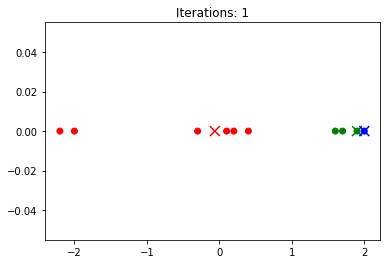

In [8]:
clusters = km.fit_predict(d)
x_centroids = km.cluster_centers_[:,0]
# Scatter plot including centroids
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
            c=range(len(x_centroids)), cmap=c)
plt.title(f'Iterations: {km.n_iter_}')
plt.show()

As expected, the centroids are still visibly positioned to the right.

## Empty centroids exception

There is one particularity of the `sklearn` implementation worth mentioning, which is not part of the basic algorithm: when a cluster is empty, the centroid will be repositioned immediately without waiting for the regular steps of the algorithm to change them. For instance, if we start with all 3 centroids at the right of the dataset, after the first iteration all points should be in a single cluster, while the remaining two centroids should be empty, so the situation should be even more unbalanced than above. However, if we try this and start with 3, 4, 5 as centroids, we instead get:

Initialization complete
Iteration 0, inertia 91.8


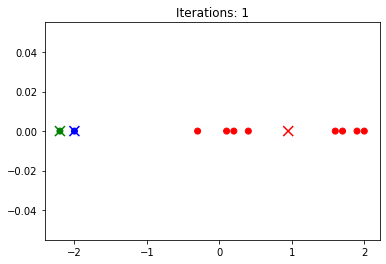

In [9]:
init_centroids = np.array([[3], [4], [5]])
km = KMeans(init=init_centroids, n_init=1, max_iter=1, n_clusters=3, verbose=1)
clusters = km.fit_predict(d)
x_centroids = km.cluster_centers_[:,0]
# Scatter plot including centroids
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
            c=range(len(x_centroids)), cmap=c)
plt.title(f'Iterations: {km.n_iter_}')
plt.show()

We find 2 of the three centroids on the extreme left of the dataset instead of the right. This prevents the algorithm from getting 'stuck' with centroids completely outside of the dataset.